# <b>CS156 (Introduction to AI), Spring 2022</b>
# <u><b>Homework 8 submission</b></u>

### Roster Name: Benjamin Wu
### Student ID: 013607880
### Email address: benjamin.wu01@sjsu.edu

##  <u>Solution</u>

## Import libraries, setup random seed

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [3]:
np.random.seed(42)

##  <u>References and sources </u>

List all your references and sources here.
This includes all sites/discussion boards/blogs/posts/etc. where you grabbed some code examples.

## Code the solution

In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./homework8_input_data/flowers/training",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./homework8_input_data/flowers/training",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./homework8_input_data/flowers/test",
    labels="inferred",
    label_mode="categorical",
    seed=42,
    image_size=image_size,
    batch_size=1,
)

Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 2
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)

In [7]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 361s 4s/step - loss: 1.2679 - accuracy: 0.5306 - val_loss: 1.7036 - val_accuracy: 0.2590
Epoch 2/20
87/87 [==============================] - 350s 4s/step - loss: 1.0068 - accuracy: 0.6264 - val_loss: 2.2392 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 330s 4s/step - loss: 0.8816 - accuracy: 0.6702 - val_loss: 3.1702 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 329s 4s/step - loss: 0.8406 - accuracy: 0.6875 - val_loss: 3.6277 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 330s 4s/step - loss: 0.7492 - accuracy: 0.7226 - val_loss: 4.0123 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 334s 4s/step - loss: 0.7332 - accuracy: 0.7251 - val_loss: 2.5233 - val_accuracy: 0.2808
Epoch 7/20
87/87 [==============================] - 330s 4s/step - loss: 0.6712 - accuracy: 0.7533 - val_loss: 1.1421 - val_accuracy: 0.6064
Epoch 8/20
87

In [8]:
labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
true_labels = []
predicted_labels = []
wrong_images = []
wrong_labels = []
actual_labels = []


for x,y in test_ds:
    pred = model.predict(x)[0]
    predicted_labels.append(np.where(np.max(pred) == pred)[0][0])
    true_labels.append(np.where(np.max(y.numpy()[0]) == y.numpy()[0])[0][0])
    if(true_labels[len(true_labels) - 1] != predicted_labels[len(predicted_labels) - 1]):
        wrong_images.append(x)
        wrong_labels.append(labels[np.where(np.max(pred) == pred)[0][0]])
        actual_labels.append(labels[np.where(np.max(y.numpy()[0]) == y.numpy()[0])[0][0]])

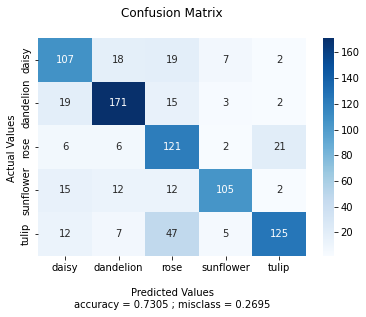

In [9]:
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy()
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

acc = ("accuracy = " + str(round((len(test_ds) - len(wrong_images)) / len(test_ds), 4)) + " ; misclass = " + str(round(len(wrong_images) / len(test_ds), 4)))

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values\n' + acc)
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## Display the visualization of the Confusion Matrix.
plt.show()

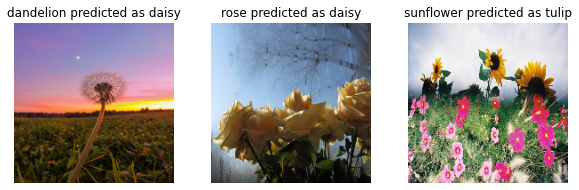

In [10]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    x = random.randint(0, len(wrong_images))
    plt.imshow(wrong_images[x][0].numpy().astype("uint8"))
    plt.title(actual_labels[x] + " predicted as " + wrong_labels[x])
    plt.axis('off')